In [8]:
#!pip install tsfel
from tsfel.feature_extraction import features as tsfelf
import numpy as np
import os
from scipy import signal
import pandas as pd
import glob
import sklearn
from scipy.io import wavfile
from scipy.signal import decimate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [9]:
source_samp_rate=44100
decimation_factor = 4
#actual samples per second. When we record 1 second of audio we get only something like 0.9 seconds because of the chunk size
chunk=4096
single_audio_frame_size=10*chunk

#Preprocessing.
Filtration and feature extraction

In [10]:
def hpf(arr,fs,lf,order):
    wbut = lf
    bbut, abut = signal.butter(order,wbut, btype='highpass', fs=fs)
    return signal.filtfilt(bbut, abut, arr)

def get_features(sig,label,fs = 44100):
    
    s_f = hpf(sig, fs, 65, 2)

    Zero_Cross = tsfelf.zero_cross(sig)
    Zero_Cross_filt = tsfelf.zero_cross(s_f)
            
    Spectral_centroid = tsfelf.spectral_centroid(sig, fs)
    Spectral_centroid_filt = tsfelf.spectral_centroid(s_f, fs)

    Spectral_spread = tsfelf.spectral_spread(sig, fs)
    Spectral_spread_filt = tsfelf.spectral_spread(s_f, fs) 
            
    STD = np.std(sig)
    STD_filt = np.std(s_f)
    
    RMS = tsfelf.rms(sig)
    RMS_filt= tsfelf.rms(s_f)
    
    kurt_filt = tsfelf.kurtosis(s_f)
    
    return [label, RMS, RMS_filt, Zero_Cross, Zero_Cross_filt, Spectral_centroid, 
     Spectral_centroid_filt, Spectral_spread, Spectral_spread_filt, STD, STD_filt, kurt_filt]

In [18]:
def get_features_from_folder_10s_samples(folder_path,label,decimation_factor):
    files=glob.glob(folder_path+"/*.wav")
    print(label, len(files))
    features_array = []
    for file_path in files:
        samplerate, sdata=wavfile.read(file_path)
        decimated_data=decimate(sdata,decimation_factor)
        sample1=decimated_data[0:int(single_audio_frame_size/decimation_factor*3)]
        sample2=decimated_data[int(single_audio_frame_size/decimation_factor*3+1):int(single_audio_frame_size/decimation_factor*6+1)]
        sample3=decimated_data[int(single_audio_frame_size/decimation_factor*6+2):int(single_audio_frame_size/decimation_factor*9+2)]
        #print(len(sample1),len(sample2),len(sample3))
        features1=get_features(sample1,label,samplerate/decimation_factor)
        features2=get_features(sample2,label,samplerate/decimation_factor)
        features3=get_features(sample3,label,samplerate/decimation_factor)
        features_array.append(features1)
        features_array.append(features2)
        features_array.append(features3)
    return features_array

def get_features_from_folder_3s_samples(folder_path,label,decimation_factor):
    print(label)
    files=glob.glob(folder_path+"/*.wav")
    print(len(files))
    features_array = []
    for file_path in files:
        samplerate, sdata=wavfile.read(file_path)
        decimated_data=decimate(sdata,decimation_factor)
        sample1=decimated_data[0:int(single_audio_frame_size/decimation_factor*3)]
        #print(len(sample1))
        features1=get_features(sample1,label,samplerate/decimation_factor)
        features_array.append(features1)
        #print(features_array)
    return features_array

In [20]:
cwd = os.getcwd()
wg_path = cwd+"/Wet gravel"
dg_path = cwd+"/Dry gravel"
dg2_path = cwd+"/Dry gravel 09_03"
da_path = cwd+"/Dry asphalt"
wa_path = cwd+"/Wet asphalt"
da2_path = cwd+"/Dry asphalt 09_03"
ice_path= cwd+"/Ice"
snow_path = cwd+"/Snow with speed"
wa2_path = cwd+"/Wet asphalt 25.2"
wg_features=np.asarray(get_features_from_folder_10s_samples(wg_path,"Wet gravel",decimation_factor))
dg_features=np.asarray(get_features_from_folder_10s_samples(dg_path,"Dry gravel",decimation_factor))
da_features=np.asarray(get_features_from_folder_10s_samples(da_path,"Dry asphalt",decimation_factor))
wa_features=np.asarray(get_features_from_folder_10s_samples(wa_path,"Wet asphalt",decimation_factor))
ice_features=np.asarray(get_features_from_folder_10s_samples(ice_path,"Ice",decimation_factor))
snow_features=np.asarray(get_features_from_folder_3s_samples(snow_path,"Snow",decimation_factor))
wa2_features=np.asarray(get_features_from_folder_3s_samples(wa2_path,"Wet asphalt",decimation_factor))
da2_features=np.asarray(get_features_from_folder_3s_samples(da2_path,"Dry asphalt",decimation_factor))
dg2_features=np.asarray(get_features_from_folder_3s_samples(dg2_path,"Dry gravel",decimation_factor))

Snow
724
Wet asphalt
186
Dry asphalt
207
Dry gravel
12


In [21]:
print(len(wg_features),len(dg_features),len(da_features),len(wa_features),len(ice_features),len(snow_features),len(wa2_features),len(da2_features),len(dg2_features))

93 246 1176 483 42 724 186 207 12


In [22]:
all_features=np.concatenate((wg_features,dg_features,da_features,wa_features,ice_features,snow_features,wa2_features,da2_features,dg2_features))

In [23]:
columnlist=["Label","RMS", "RMS_filt","Zero_Cross", "Zero_Cross_filt", "Spectral_centroid", "Spectral_centroid_filt", "Spectral_spread", \
                        "Spectral_spread_filt", "STD", "STD_filt", "kurt_filt"]
roadtype_features_df=pd.DataFrame(all_features,columns=columnlist)
roadtype_features_df.head()

,Label,RMS,RMS_filt,Zero_Cross,Zero_Cross_filt,Spectral_centroid,Spectral_centroid_filt,Spectral_spread,Spectral_spread_filt,STD,STD_filt,kurt_filt
0,Wet gravel,121.92391460938127,85.87118160323317,1120,1674,712.590499680659,812.0604470477313,900.8488695369704,920.8849937463609,121.92284557295439,85.8711724481287,-0.3624601373656495
1,Wet gravel,118.56077762961824,82.954566641256,1603,2353,836.8418452474989,959.8708169616173,1023.9019867604572,1052.362947659002,118.5597027287074,82.95455054014292,-0.06392442828365796
2,Wet gravel,143.70605958900202,105.4227313476053,3033,4376,1273.9581217320942,1420.2785316389406,1242.6124586103792,1233.8428115719548,143.7045981452574,105.42272665761868,0.18863861982081298
3,Wet gravel,180.74153438104145,133.43676214748328,3092,4087,1165.0997236240394,1327.8755292837186,1232.0124702293285,1235.471666105919,180.74103423541672,133.43675499075238,2.3686710438106395
4,Wet gravel,297.383142956495,233.13526339142138,4443,5729,1466.8412660916533,1608.260925200598,1333.4576797490986,1316.249909031341,297.3824295936254,233.13524493170874,1.4125485144263976


In [24]:
print(len(roadtype_features_df))
roadtype_features_df = roadtype_features_df.dropna()
print(len(roadtype_features_df))

3169
3169


In [25]:
y=roadtype_features_df["Label"]
print(len(y))
features=["RMS", "RMS_filt","Zero_Cross", "Zero_Cross_filt", "Spectral_centroid", "Spectral_centroid_filt", "Spectral_spread", \
                        "Spectral_spread_filt", "STD", "STD_filt", "kurt_filt"]
X=roadtype_features_df[features]
X.head()

3169


,RMS,RMS_filt,Zero_Cross,Zero_Cross_filt,Spectral_centroid,Spectral_centroid_filt,Spectral_spread,Spectral_spread_filt,STD,STD_filt,kurt_filt
0,121.92391460938127,85.87118160323317,1120,1674,712.590499680659,812.0604470477313,900.8488695369704,920.8849937463609,121.92284557295439,85.8711724481287,-0.3624601373656495
1,118.56077762961824,82.954566641256,1603,2353,836.8418452474989,959.8708169616173,1023.9019867604572,1052.362947659002,118.5597027287074,82.95455054014292,-0.06392442828365796
2,143.70605958900202,105.4227313476053,3033,4376,1273.9581217320942,1420.2785316389406,1242.6124586103792,1233.8428115719548,143.7045981452574,105.42272665761868,0.18863861982081298
3,180.74153438104145,133.43676214748328,3092,4087,1165.0997236240394,1327.8755292837186,1232.0124702293285,1235.471666105919,180.74103423541672,133.43675499075238,2.3686710438106395
4,297.383142956495,233.13526339142138,4443,5729,1466.8412660916533,1608.260925200598,1333.4576797490986,1316.249909031341,297.3824295936254,233.13524493170874,1.4125485144263976


In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

KNN confusion matrix


C:\Users\AtteR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


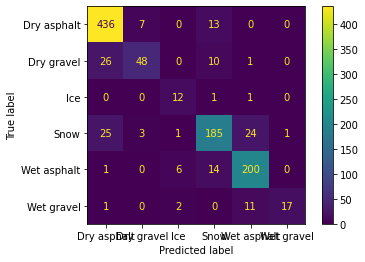

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
print("KNN confusion matrix")
plot_confusion_matrix(knn, x_test, y_test)


In [30]:
trues=0
for true,pred in zip(y_test,y_pred_knn):
    if(true==pred):
        trues=trues+1
print(trues/len(y_test))

0.858508604206501


Let's do some scaling

In [31]:
scaled_df=roadtype_features_df.copy()
scaler = preprocessing.StandardScaler()
scaled_df[features]=scaler.fit_transform(scaled_df[features])
scaled_df.head()

,Label,RMS,RMS_filt,Zero_Cross,Zero_Cross_filt,Spectral_centroid,Spectral_centroid_filt,Spectral_spread,Spectral_spread_filt,STD,STD_filt,kurt_filt
0,Wet gravel,-1.125801,-1.078709,-1.694441,-1.705003,-1.131146,-1.103693,-0.062070,0.178363,-1.125801,-1.078709,-0.214044
1,Wet gravel,-1.126435,-1.079290,-1.458059,-1.364402,-0.737083,-0.618022,0.918959,1.242867,-1.126435,-1.079290,-0.189545
2,Wet gravel,-1.121699,-1.074818,-0.758211,-0.349620,0.649228,0.894772,2.662608,2.712209,-1.121699,-1.074818,-0.168818
3,Wet gravel,-1.114723,-1.069242,-0.729336,-0.494589,0.303984,0.591157,2.578100,2.725397,-1.114723,-1.069242,0.010090
4,Wet gravel,-1.092754,-1.049399,-0.068150,0.329075,1.260955,1.512439,3.386863,3.379414,-1.092754,-1.049399,-0.068376


KNN_with_scaling confusion matrix


C:\Users\AtteR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


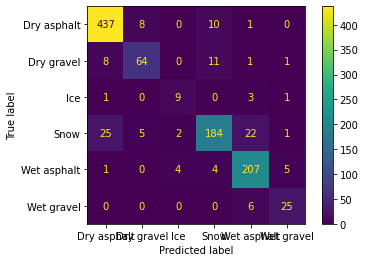

In [32]:
y=scaled_df["Label"]
X=scaled_df[features]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)
knn_with_scaling = KNeighborsClassifier(n_neighbors=3)
knn_with_scaling.fit(x_train, y_train)
y_pred_knn = knn_with_scaling.predict(x_test)
print("KNN_with_scaling confusion matrix")
plot_confusion_matrix(knn_with_scaling, x_test, y_test)

In [33]:
trues=0
for true,pred in zip(y_test,y_pred_knn):
    if(true==pred):
        trues=trues+1
print(trues/len(y_test))

0.8852772466539197


In [34]:
filename="df-"+str(decimation_factor)+"_wl-3s_"+"09.03.2022.csv"
roadtype_features_df.to_csv(filename,index=False)